# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5


---
__Name:__  Nilesh Bhoyar   
__Class:__ MIDS w261 (Section *Your Section Goes Here*, e.g., Fall 2016 Group 1)     
__Email:__  nilesh.bhoyar@iSchool.Berkeley.edu     
__Week:__   5

__Due Time:__ 2 Phases. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the AltaScale cluster and will be due Tuesday, Week 7 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. This will be a group exercise 


# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale   
DATSCIW261 ASSIGNMENT #5

Version 2017-9-2 


### IMPORTANT

This homework must be completed in the cloud 

### === INSTRUCTIONS for SUBMISSIONS ===   
Follow the instructions for submissions carefully.

Each student has a `HW-<user>` repository for all assignments.   

Click this link to enable you to create a github repo within the MIDS261 Classroom:   
https://classroom.github.com/assignment-invitations/3b1d6c8e58351209f9dd865537111ff8   
and follow the instructions to create a HW repo.

Push the following to your HW github repo into the master branch:
* Your local HW5 directory. Your repo file structure should look like this:

```
HW-<user>
    --HW3
       |__MIDS-W261-HW-03-<Student_id>.ipynb
       |__MIDS-W261-HW-03-<Student_id>.pdf
       |__some other hw3 file
    --HW4
       |__MIDS-W261-HW-04-<Student_id>.ipynb
       |__MIDS-W261-HW-04-<Student_id>.pdf
       |__some other hw4 file
    etc..
```    

<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="5.4"></a> 
# PHASE 2
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.executable


'/home/nileshbhoyar/.conda/envs/py27/bin/python'

In [3]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import  combinations
class MRbuildStripes(MRJob):
  
  #START SUDENT CODE531_STRIPES
    SORT_VALUES = True
   
    #def __init__(self, *args, **kwargs):
    #    super(MRjoins, self).__init__(*args, **kwargs)
        
  
               
    
        
    def mapper(self, _, recs):
        self.increment_counter('Execution Counts', 'mapper calls', 1)
        fields = recs.split("\t")
        
        products = fields[0].lower().replace('\n','').split()
        for i, term in enumerate(products):
                # Create a new stripe for each term
                stripe = {}

                for j, token in enumerate(products):
                    # Don't count the term's co-occurrence with itself
                    if i != j:
                        x = stripe.get(token,None)
                        if x == None:
                            stripe[token] = int( fields[1])
                        else:
                            stripe[token] += int(fields[1])

                # Emit the term and the stripe
                yield term, stripe
    
    def combiner(self, word, stripes):
        yield word, self.combine_stripes(stripes)

    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += int(value)
                else:
                    combined_stripe[key] = int(value)

        return combined_stripe
    def reducer(self,key, records):
        yield key, self.combine_stripes(records)
        
    def steps(self):  #pipeline of Map-Reduce jobs
        step = MRStep( 
                    mapper=self.mapper,       # STEP 1: word count step
                    combiner = self.combiner,
                    reducer=self.reducer
                    )
        return [step]
            


  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
  MRbuildStripes.run()

Writing buildStripes.py


In [4]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol
class MRinvertedIndex(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    SORT_VALUES = True
#START SUDENT CODE531_INV_INDEX
    def mapper_normalize_transpose(self, word, rate_stripe):

        # First compute the magnitude for the vector.

        #magnitude = math.sqrt(sum([value ** 2 for value in rate_stripe.itervalues()]))

        # Divide each value in the vector by the magnitude to normalize.
        length = len(rate_stripe)
        for key, value in rate_stripe.iteritems():
            #normalized_value = value / magnitude
            yield key, { word: length}
    def combiner_normalize_transpose(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)
    def reducer_normalize_transpose(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

        
    def steps(self):

        transpose_step = MRStep(
            mapper = self.mapper_normalize_transpose,
            combiner = self.combiner_normalize_transpose,
            reducer = self.reducer_normalize_transpose)
        return [transpose_step]

#END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Writing invertedIndex.py


In [5]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class MRsimilarity(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    SORT_VALUES = True

#START SUDENT CODE531_SIMILARITY
    def mapper_jaccard(self, word, rate_stripe):
        #get all words and lengths
#We will emit stripes for each word vector here.  These stripes will
#be used in combiner to find the common length i.e. words occuring together
        nonzero_keys = [key for key, value in rate_stripe.iteritems() if value != 0]

    

        sorted_keys = sorted(nonzero_keys)
        # N * N  complexity matrix calculation
        #We are going over each record to find out the common occureances
        for i in range(0, len(sorted_keys)):
            left_label = sorted_keys[i]

            stripe = {}

            for j in range(i + 1, len(sorted_keys)):
                right_label = sorted_keys[j]
                stripe[right_label] = 1

            yield left_label, stripe

     

        for key in sorted_keys:
            yield '*',{key:1}
            #{u'DocC': 1}
        #yield '*', { key: 1 for key in sorted_keys }
    def combiner_jaccard(self, left_label, partial_stripes):
        yield left_label, self.combine_stripes(partial_stripes)

#find out the jaccard values.
    def reducer_jaccard(self, left_label, partial_stripes):
        total_stripe = self.combine_stripes(partial_stripes)
        #this stores the total length of each word Vector
        if left_label == '*':
            self.total_counts = total_stripe
            return

        for right_label, intersection_size in total_stripe.iteritems():
            coordinate = (left_label, right_label)
            union_size = self.total_counts[left_label] + self.total_counts[right_label]

            
            jaccard_distance = float(intersection_size)/float(union_size - intersection_size) #jaccard
            dice_coef = (float(intersection_size) * 2 )/float(union_size ) #dice Coefficient
            final = {}
            final['jaccard'] = jaccard_distance
            final['dice'] = dice_coef
            yield coordinate, final

#in-memory combiner
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

   
    def steps(self):
         distance_step = MRStep(
                mapper = self.mapper_jaccard,
                combiner = self.combiner_jaccard,
                reducer = self.reducer_jaccard,
                jobconf = {
                    'mapreduce.job.reduces': 1
                    
                })
         return [distance_step]
#END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    MRsimilarity.run()

Writing similarity.py


In [6]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Writing googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


In [7]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Writing atlas-boon-systems-test.txt


In [8]:
#copy all files on local folder

!rm -r /home/nileshbhoyar/data
!hdfs dfs -copyToLocal hdfs:///user/cendylin/filtered-5Grams/ /home/nileshbhoyar/data

In [9]:
#!hdfs dfs rm --recursive systems_test_stripes_1
!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1
!cat systems_test_stripes_1

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/buildStripes.nileshbhoyar.20170623.130721.532942
Running step 1 of 1...
Counters: 1
	Execution Counts
		mapper calls=10
Counters: 1
	Execution Counts
		mapper calls=10
Streaming final output from /tmp/buildStripes.nileshbhoyar.20170623.130721.532942/output...
Removing temp directory /tmp/buildStripes.nileshbhoyar.20170623.130721.532942...
"forms"	{"a":116,"of":232,"collection":116}
"general"	{"a":92,"of":92,"george":92,"biography":92}
"george"	{"a":92,"of":92,"biography":92,"general":92}
"government"	{"a":102,"case":102,"study":102,"in":102}
"in"	{"a":1201,"case":102,"government":102,"study":102,"child's":1099,"wales":1099,"christmas":1099}
"limited"	{"a":55,"case":55,"study":55,"of":55}
"narrative"	{"a":62,"of":62,"the":62,"circumstantial":62}
"of"	{"a":1011,"case":502,"circumstantial":62,"geo

In [10]:
###########################################################################
# Make Stripes from ngrams for systems test 2
###########################################################################

!hdfs dfs rm --recursive systems_test_stripes_2
!python buildStripes.py -r local atlas-boon-systems-test.txt > systems_test_stripes_2

rm: Unknown command
Did you mean -rm?  This command begins with a dash.
No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/buildStripes.nileshbhoyar.20170623.130723.480051
Running step 1 of 1...
Counters: 1
	Execution Counts
		mapper calls=3
Counters: 1
	Execution Counts
		mapper calls=3
Streaming final output from /tmp/buildStripes.nileshbhoyar.20170623.130723.480051/output...
Removing temp directory /tmp/buildStripes.nileshbhoyar.20170623.130723.480051...


In [11]:
with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3  

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


In [12]:
!python invertedIndex.py -r local systems_test_stripes_1 > systems_test_index_1
!python invertedIndex.py -r local systems_test_stripes_2 > systems_test_index_2
!python invertedIndex.py -r local systems_test_stripes_3 > systems_test_index_3

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/invertedIndex.nileshbhoyar.20170623.130724.961909
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.nileshbhoyar.20170623.130724.961909/output...
Removing temp directory /tmp/invertedIndex.nileshbhoyar.20170623.130724.961909...
No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/invertedIndex.nileshbhoyar.20170623.130726.185050
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.nileshbhoyar.20170623.130726.185050/output...
Removing temp directory /tmp/invertedIndex.nileshbhoyar.20170623.130726.185050...
No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org

In [13]:
##########################################################
# Pretty print systems tests for generating Inverted Index
##########################################################

import json

for i in range(1,4):
    print "—"*100
    print "Systems test ",i," - Inverted Index"
    print "—"*100  
    with open("systems_test_index_"+str(i),"r") as f:
        lines = sorted(f.readlines())
        for line in lines:
            line = line.strip()
            word, doc_list = line.split("\t")
            doc_dict = json.loads(doc_list)
            stripe=[]
            for doc in doc_dict:
                stripe.append([doc, doc_dict[doc]])
            stripe=sorted(stripe)
            stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

            print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format(
              (word), stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))

————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
             "a" |          bill 4 |     biography 4 |            by 4
          "bill" |            a 27 |  establishing 4 |           for 4
     "biography" |            a 27 |       general 4 |        george 4
            "by" |            a 27 |          city 4 |           sea 4
          "case" |            a 27 |        female 4 |    government 4
       "child's" |            a 27 |     christmas 4 |            in 7
     "christmas" |            a 27 |       child's 4 |            in 7
"circumstantial" |            a 27 |     narrative 4 |           of 16
          "city" |            a 27 |            by 4 |           sea 4
    "collection" |            a 27 |         fairy 4 |         forms 3
  "establishing" |            a 27 |          bill 4 |

In [14]:
!python similarity.py -r hadoop systems_test_index_1 --cmdenv PATH=/opt/anaconda/bin:$PATH  > systems_test_similarities_1

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.nileshbhoyar.20170623.130728.790107
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/similarity.nileshbhoyar.20170623.130728.790107/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3854595593

In [15]:
!python similarity.py -r hadoop systems_test_index_3 --cmdenv PATH=/opt/anaconda/bin:$PATH > systems_test_similarities_3

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.nileshbhoyar.20170623.130845.345104
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/similarity.nileshbhoyar.20170623.130845.345104/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4878511891

In [18]:
!python similarity.py -r hadoop systems_test_index_2 --cmdenv PATH=/opt/anaconda/bin:$PATH > systems_test_similarities_2

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.nileshbhoyar.20170623.131246.496488
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/similarity.nileshbhoyar.20170623.131246.496488/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1668193155

In [19]:
############################################
# Pretty print systems tests
############################################

import json
for i in range(3,0,-1):
  print '—'*110
  print "Systems test ",i," - Similarity measures"
  print '—'*110
  print "{0:>15} |{1:>15}|{2:>15}".format(
           "pair",  "jaccard","Dice")
  print '-'*110

  with open("systems_test_similarities_"+str(i),"r") as f:
      lines = f.readlines()
      for line in lines:
          line = line.strip()
          pair,stripe = line.split("\t")
          stripe = json.loads(stripe)
     
          print "{0:>15} |{1:>15f}|{2:>15f}".format(
              pair,float(stripe['jaccard']),float(stripe['dice'] ))
#          print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
#               float(avg), stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))
          #print 
 

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  3  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
           pair |        jaccard|           Dice
--------------------------------------------------------------------------------------------------------------
["DocA", "DocB"] |       0.666667|       0.800000
["DocA", "DocC"] |       0.400000|       0.571429
["DocB", "DocC"] |       0.200000|       0.333333
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  2  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
           pair |        jaccard|           Dice
--------------------------------------------------------------------------------------------------------------
["atlas"

["child's", "circumstantial"] |       0.142857|       0.250000
["child's", "of"] |       0.052632|       0.100000
["child's", "study"] |       0.222222|       0.363636
["child's", "establishing"] |       0.142857|       0.250000
["child's", "narrative"] |       0.142857|       0.250000
["child's", "the"] |       0.100000|       0.181818
["christmas", "limited"] |       0.142857|       0.250000
["christmas", "circumstantial"] |       0.142857|       0.250000
["christmas", "sea"] |       0.142857|       0.250000
["christmas", "for"] |       0.142857|       0.250000
["christmas", "city"] |       0.142857|       0.250000
["christmas", "of"] |       0.052632|       0.100000
["christmas", "study"] |       0.222222|       0.363636
["christmas", "government"] |       0.333333|       0.500000
["christmas", "collection"] |       0.125000|       0.222222
["christmas", "establishing"] |       0.142857|       0.250000
["christmas", "forms"] |       0.166667|       0.285714
["christmas", "narrative"

["in", "limited"] |       0.375000|       0.545455
   ["in", "of"] |       0.150000|       0.260870
["in", "study"] |       0.272727|       0.428571
  ["in", "sea"] |       0.100000|       0.181818
["in", "narrative"] |       0.100000|       0.181818
["in", "wales"] |       0.375000|       0.545455
  ["in", "the"] |       0.076923|       0.142857
["in", "religious"] |       0.100000|       0.181818
["in", "tales"] |       0.100000|       0.181818
["limited", "of"] |       0.250000|       0.400000
["limited", "study"] |       0.375000|       0.545455
["limited", "sea"] |       0.142857|       0.250000
["limited", "narrative"] |       0.333333|       0.500000
["limited", "wales"] |       0.142857|       0.250000
["limited", "the"] |       0.222222|       0.363636
["limited", "religious"] |       0.142857|       0.250000
["limited", "tales"] |       0.333333|       0.500000
["narrative", "of"] |       0.250000|       0.400000
["narrative", "study"] |       0.222222|       0.363636
["narra

## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [20]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
class longest5gram(MRJob):
    
    # START STUDENT CODE 5.4.1.A
    

    def mapper(self, _,recs):
        fields = recs.split("\t")
        ngram_length = len(fields[0])
        yield None, (ngram_length, fields[0])

   
    def combiner(self, _, pairs):
        yield None, self.get_longest_ngram(pairs)

   
    def reducer(self, _, pairs):
        ngram_length, ngram = self.get_longest_ngram(pairs)
        yield None,(ngram_length, ngram)
    def reducer_second(self, _,pairs):
        ngram_length, ngram = self.get_longest_ngram(pairs)
        yield ngram_length, ngram
        #yield None,pairs
    
    def get_longest_ngram(self, pairs):
        longest_ngram = None
        longest_ngram_length = 0

        for ngram_length, ngram in pairs:
            if ngram_length > longest_ngram_length:
                longest_ngram = ngram
                longest_ngram_length = ngram_length
            elif ngram_length == longest_ngram_length and ngram < longest_ngram:
                longest_ngram = ngram

        return longest_ngram_length, longest_ngram
    def steps(self):  #pipeline of Map-Reduce jobs
     
        return [
            MRStep( 
                    mapper=self.mapper,       
                    combiner=self.combiner,
                    reducer=self.reducer,
                    jobconf = {
                    'mapreduce.job.reduces': 5,
                    'mapreduce.reduce.cpu.vcores':8
                }
                
            ),
            MRStep(reducer=self.reducer_second,
                  jobconf = {
                    'mapreduce.job.reduces': 1,
                    'mapreduce.reduce.cpu.vcores':8
                }
                  ) # Step 2: most frequent word
        ]


    # END STUDENT CODE 5.4.1.A
    
if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    longest5gram().run()

Writing longest5gram.py


__On test data set:__

In [21]:
#!python longest5gram.py -r hadoop "hdfs:///user/cendylin/filtered-5Grams/*.txt" > outputlongest.txt
%time !python longest5gram.py -r local "googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt" 

No configs found; falling back on auto-configuration
Creating temp directory /tmp/longest5gram.nileshbhoyar.20170623.131503.863777
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/longest5gram.nileshbhoyar.20170623.131503.863777/output...
33	"A BILL FOR ESTABLISHING RELIGIOUS"
Removing temp directory /tmp/longest5gram.nileshbhoyar.20170623.131503.863777...
CPU times: user 33 ms, sys: 5 ms, total: 38 ms
Wall time: 1.24 s


__On full data set:__

In [22]:
#!python longest5gram.py -r hadoop "hdfs:///user/cendylin/filtered-5Grams/*.txt" > outputlongest.txt
%time !python longest5gram.py -r hadoop "hdfs:///user/cendylin/filtered-5Grams/" > outputlongest.txt

No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/longest5gram.nileshbhoyar.20170623.131510.745767
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/longest5gram.nileshbhoyar.20170623.131510.745767/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2027824696222385117.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline

Removing HDFS temp directory hdfs:///user/nileshbhoyar/tmp/mrjob/longest5gram.nileshbhoyar.20170623.131510.745767...
Removing temp directory /tmp/longest5gram.nileshbhoyar.20170623.131510.745767...
CPU times: user 8.65 s, sys: 1.87 s, total: 10.5 s
Wall time: 6min 22s


## Report Stats: 
#### Step1
##### No of maps 190
##### No of Reducers  10
#### Total time for haddop jobs 1mins, 19sec
#### Step 2
##### No of reducers 1
##### No of maps 2
##### Total time 17 sec

Step 1
http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_1907

Step 2
http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_1909

In [23]:
!cat outputlongest.txt

159	"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"


In [20]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /home/nileshbhoyar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### HW5.4.1 - B. Top 10 most frequent words 

In [24]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol

#from mrjob.protocol import  RawValueProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

from collections import defaultdict

class mostFrequentWords(MRJob):
    INPUT_PROTOCOL = RawProtocol
    
   
    
    # START STUDENT CODE 5.4.1.B
    INPUT_PROTOCOL = RawProtocol
    MRJob.SORT_VALUES = True
    
    def mapper(self, key, value):
        words = re.findall("\w+", key.lower())
        #words =word_tokenize(key.lower())

        for word in words:
            yield word,1

  
    def combiner(self, word, counts):
      
         yield word, sum(counts)   

    def reducer(self, word, counts):

         yield word, sum(counts)
    def steps(self):
        return [
            MRStep( 
                    mapper=self.mapper,
                    combiner=self.combiner,
                    reducer=self.reducer,
                    jobconf = {
                    'mapreduce.job.reduces': 40,
                    'mapreduce.reduce.cpu.vcores':8
                    }
                  ),]
  
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Writing mostFrequentWords.py


__On the test data set:__

In [25]:
!python mostFrequentWords.py -r local "googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt" > mostfrequent.txt
!cat mostfrequent.txt

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/mostFrequentWords.nileshbhoyar.20170623.132133.734214
Running step 1 of 1...
Streaming final output from /tmp/mostFrequentWords.nileshbhoyar.20170623.132133.734214/output...
Removing temp directory /tmp/mostFrequentWords.nileshbhoyar.20170623.132133.734214...
"collection"	2
"in"	2
"forms"	1
"bill"	1
"s"	1
"sea"	1
"george"	1
"limited"	1
"the"	2
"for"	1
"circumstantial"	1
"by"	1
"case"	3
"establishing"	1
"child"	1
"biography"	1
"a"	10
"wales"	1
"of"	7
"narrative"	1
"city"	1
"government"	1
"christmas"	1
"general"	1
"female"	1
"religious"	1
"tales"	1
"fairy"	1
"study"	3


__On the full data set:__

In [37]:
!hdfs dfs -mkdir hdfs:///user/nileshbhoyar/output/
!hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW541/
%time !python mostFrequentWords.py \
        -r hadoop \
        --output-dir="hdfs:///user/nileshbhoyar/output/HW541/"\
        --no-output \
        "hdfs:///user/cendylin/filtered-5Grams/" 
            

mkdir: `hdfs:/user/nileshbhoyar/output': File exists
17/06/23 13:47:50 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/output/HW541' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/mostFrequentWords.nileshbhoyar.20170623.134751.553162
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/mostFrequentWords.nileshbhoyar.20170623.134751.553162/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred

In [38]:
!rm frequentwords.txt
!hdfs dfs -cat hdfs:///user/nileshbhoyar/output/HW541/* > frequentwords.txt

In [39]:
!sort -k2nr -k1 frequentwords.txt > frequentwords.txt_sorted.txt

In [40]:
!head -10 frequentwords.txt_sorted.txt

"the"	27502442
"of"	18191779
"to"	12075972
"in"	7881254
"a"	7853623
"and"	7767901
"that"	4327887
"is"	3847383
"be"	3288734
"for"	2763614


In [41]:
!head -10000 frequentwords.txt_sorted.txt > vocabulary.txt
!head -10000 frequentwords.txt_sorted.txt | tail -1000 > basis.txt

## Most frequent words MR stats
    
    
    
__Step 1:__   

    RUNNING for 2mins, 51sec 
    Launched map tasks=190 
    Launched reduce tasks=3 sec   

    Job Name:	streamjob8293326753705703331.jar
    User Name:	nileshbhoyar
    Queue:	berkeley
    State:	SUCCEEDED
    Uberized:	false
    Submitted:	Thu Jun 22 14:13:24 UTC 2017
    Started:	Thu Jun 22 14:16:05 UTC 2017
    Finished:	Thu Jun 22 14:25:40 UTC 2017
    Elapsed:	9mins, 35sec
    Diagnostics:	
    Average Map Time	2mins, 51sec
    Average Shuffle Time	3sec
    Average Merge Time	0sec
    Average Reduce Time	3sec
http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_1912/mapreduce/job/job_1497906899862_1912

### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [30]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

import time
import logging

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.4.1.C
    def mapper1(self, _, line):
        line = line.strip()
        tabs = line.split('\t')
        words = tabs[0].split(' ')
        for word1 in words:
            yield ''.join(words),word1
                    
    def reducer1(self, key , values):
        word2list={}
        for value in values:
            if value not in word2list:
                word2list[value]=1
            else:
                word2list[value]+=1
        yield key,word2list
            
    def mapper2(self, key , values):
        for v in values:
            yield v,(values[v],1)
                    
    def combiner2(self, key , values):
        tf=0
        idf=0
        for pair in values:
            tf+=pair[0]
            idf+=pair[1]
        yield key,(tf,idf)
        
    def reducer2(self, key , values):
        tf=0
        idf=0
        for pair in values:
            tf+=pair[0]
            idf+=pair[1]
        yield key,(tf/idf)

    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options':'-nrk2',
            'mapreduce.partition.keycomparator.options':'-nrk2',
           
            
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [MRStep(jobconf=JOBCONF_STEP1,mapper=self.mapper1,reducer=self.reducer1
                      ),
                MRStep(mapper=self.mapper2,combiner=self.combiner2,reducer=self.reducer2,jobconf={
                    'mapred.map.tasks': 190,
                    'mapreduce.reduce.cpu.vcores':8
                        }
                      )
               ]
    # END STUDENT CODE 5.4.1.C
        
if __name__ == '__main__':
    start_time = time.time()
    mostLeastDenseWords.run()
    elapsed_time = time.time() - start_time
    a = 'time elapsed:', str(elapsed_time)
    logging.warning(a)

Writing mostLeastDenseWords.py


__On the test data set:__

In [31]:

!rm mostLeastDenseWords.txt
!python mostLeastDenseWords.py -r local "googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt" > mostLeastDenseWords.txt

rm: cannot remove `mostLeastDenseWords.txt': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/mostLeastDenseWords.nileshbhoyar.20170623.132140.228575
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostLeastDenseWords.nileshbhoyar.20170623.132140.228575/output...
Removing temp directory /tmp/mostLeastDenseWords.nileshbhoyar.20170623.132140.228575...


In [32]:
!cat mostLeastDenseWords.txt | sort -nrk2 | head -20
!cat mostLeastDenseWords.txt | sort -nrk2 | head -20

"of"	1.1666666667
"the"	1.0
"in"	1.0
"by"	1.0
"Wales"	1.0
"Tales"	1.0
"Study"	1.0
"Sea"	1.0
"RELIGIOUS"	1.0
"Narrative"	1.0
"Limited"	1.0
"Government"	1.0
"George"	1.0
"General"	1.0
"Forms"	1.0
"Female"	1.0
"Fairy"	1.0
"FOR"	1.0
"ESTABLISHING"	1.0
"Collection"	1.0
"of"	1.1666666667
"the"	1.0
"in"	1.0
"by"	1.0
"Wales"	1.0
"Tales"	1.0
"Study"	1.0
"Sea"	1.0
"RELIGIOUS"	1.0
"Narrative"	1.0
"Limited"	1.0
"Government"	1.0
"George"	1.0
"General"	1.0
"Forms"	1.0
"Female"	1.0
"Fairy"	1.0
"FOR"	1.0
"ESTABLISHING"	1.0
"Collection"	1.0


__On the full data set:__

In [33]:
!hdfs dfs -mkdir hdfs:///user/nileshbhoyar/output/
!hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW541C/
%time !python mostLeastDenseWords.py \
        -r hadoop \
        --output-dir="hdfs:///user/nileshbhoyar/output/HW541C/"\
        --no-output \
        "hdfs:///user/cendylin/filtered-5Grams/" 
            

mkdir: `hdfs:/user/nileshbhoyar/output': File exists
17/06/23 13:21:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/output/HW541C' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/mostLeastDenseWords.nileshbhoyar.20170623.132148.216070
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/mostLeastDenseWords.nileshbhoyar.20170623.132148.216070/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 m

   map 100% reduce 74%
   map 100% reduce 75%
   map 100% reduce 76%
   map 100% reduce 77%
   map 100% reduce 78%
   map 100% reduce 79%
   map 100% reduce 80%
   map 100% reduce 81%
   map 100% reduce 82%
   map 100% reduce 83%
   map 100% reduce 84%
   map 100% reduce 85%
   map 100% reduce 86%
   map 100% reduce 87%
   map 100% reduce 88%
   map 100% reduce 89%
   map 100% reduce 90%
   map 100% reduce 91%
   map 100% reduce 92%
   map 100% reduce 93%
   map 100% reduce 94%
   map 100% reduce 95%
   map 100% reduce 96%
   map 100% reduce 97%
   map 100% reduce 98%
   map 100% reduce 99%
   map 100% reduce 100%
  Job job_1497906899862_2487 completed successfully
  Output directory: hdfs:///user/nileshbhoyar/output/HW541C/
Counters: 50
	File Input Format Counters 
		Bytes Read=4805773657
	File Output Format Counters 
		Bytes Written=5412281
	File System Counters
		FILE: Number of bytes read=24748610
		FILE: Number of bytes written=123678120
		FILE: Number of large read operations=0
	

In [34]:
!hdfs dfs -ls hdfs:///user/nileshbhoyar/output/HW541C/
!hdfs dfs -cat hdfs:/user/nileshbhoyar/output/HW541C/part-* > final_density.txt

Found 2 items
-rw-r--r--   3 nileshbhoyar users          0 2017-06-23 13:47 hdfs:/user/nileshbhoyar/output/HW541C/_SUCCESS
-rw-r--r--   3 nileshbhoyar users    5412281 2017-06-23 13:47 hdfs:/user/nileshbhoyar/output/HW541C/part-00000


In [35]:
!sort -k2nr final_density.txt > sorted_density.txt

In [36]:
!head  -20  sorted_density.txt

"IOOO"	5.0
"MeO"	5.0
"OMe"	5.0
"OOOOOO"	5.0
"PIC"	5.0
"Quintile"	5.0
"llll"	5.0
"nnn"	5.0
"oooooooooooooooo"	5.0
"xxxx"	5.0
"xxxxxxxx"	5.0
"OOOOO"	4.2857142857142856
"CHOH"	4.0
"oooooooo"	4.0
"ooooo"	3.875
"IIII"	3.6666666666666665
"oooooo"	3.5
"ARCHIE"	3.0
"Cosine"	3.0
"Crystalloid"	3.0


## Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    Job Name:	streamjob3040269206354443932.jar
    User Name:	nileshbhoyar
    Queue:	berkeley
    State:	SUCCEEDED
    Uberized:	false
    Submitted:	Thu Jun 22 17:47:41 UTC 2017
    Started:	Thu Jun 22 17:47:49 UTC 2017
    Finished:	Thu Jun 22 17:54:08 UTC 2017
    Elapsed:	6mins, 19sec
    Diagnostics:	
    Average Map Time	1mins, 10sec
    Average Shuffle Time	4sec
    Average Merge Time	7sec
    Average Reduce Time	4mins, 9sec
 
http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_2043/mapreduce/job/job_1497906899862_2043

step 2

    Job Name:	streamjob810535679113074807.jar
    User Name:	nileshbhoyar
    Queue:	berkeley
    State:	SUCCEEDED
    Uberized:	false
    Submitted:	Thu Jun 22 17:54:18 UTC 2017
    Started:	Thu Jun 22 17:54:28 UTC 2017
    Finished:	Thu Jun 22 18:08:51 UTC 2017
    Elapsed:	14mins, 22sec
    Diagnostics:	
    Average Map Time	5mins, 25sec
    Average Shuffle Time	3sec
    Average Merge Time	5sec
    Average Reduce Time	5mins, 36sec
 
 http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_2049/mapreduce/job/job_1497906899862_2049

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [46]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    counter=0
    # START STUDENT CODE 5.4.1.D
    def mapper(self, _, line):
        line = line.strip()
        tabs = line.split('\t')
        words = tabs[0]
        yield len(words),1
    def combiner(self,key,value):
        yield key,sum(value)
    def reducer(self, key , value):
        yield key,sum(value)

    def steps(self):
        return [MRStep(mapper=self.mapper,combiner=self.combiner,reducer=self.reducer,jobconf={
            'mapred.map.tasks': 190,
		    'mapreduce.reduce.cpu.vcores':8
        })]
    # END STUDENT CODE 5.4.1.D
    
if __name__ == '__main__':
    distribution.run()

Writing distribution.py


In [47]:

!hdfs dfs rm --recursive systems_test_distribution
!python distribution.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_distribution.txt

rm: Unknown command
Did you mean -rm?  This command begins with a dash.
No configs found; falling back on auto-configuration
Creating temp directory /tmp/distribution.nileshbhoyar.20170623.140355.472491
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/distribution.nileshbhoyar.20170623.140355.472491/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob9034149022049265941.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to R

In [48]:

!cat systems_test_distribution.txt | sort -nrk1,1

33	2
29	1
28	1
27	1
26	1
24	1
23	1
22	1
17	1


__On the test data set:__

__On the full data set:__

In [49]:


!hdfs dfs -mkdir hdfs:///user/nileshbhoyar/output/
!hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW541D/
%time !python distribution.py \
        -r hadoop \
        --output-dir="hdfs:///user/nileshbhoyar/output/HW541D/"\
        --no-output \
        "hdfs:///user/cendylin/filtered-5Grams/"

mkdir: `hdfs:/user/nileshbhoyar/output': File exists
rm: `hdfs:///user/nileshbhoyar/output/HW541D/': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/distribution.nileshbhoyar.20170623.140551.232466
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/distribution.nileshbhoyar.20170623.140551.232466/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob366480745319286911.jar tmpDir=null
  Timeline service address: http://rm-ia.s3

In [51]:
!rm full_distribution.txt
!hdfs dfs -cat hdfs:///user/nileshbhoyar/output/HW541D/part* |sort -nk1,1 > full_distribution.txt

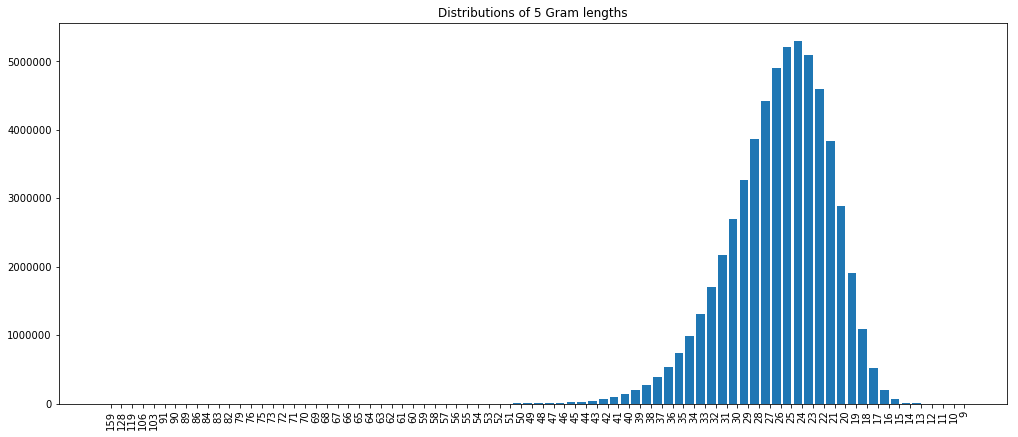

In [52]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("full_distribution.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of 5 Gram lengths")
pl.show()

## Distribution MRJob stats

    Job Name:	streamjob1829799781120004028.jar
    User Name:	nileshbhoyar
    Queue:	berkeley
    State:	SUCCEEDED
    Uberized:	false
    Submitted:	Thu Jun 22 17:40:18 UTC 2017
    Started:	Thu Jun 22 17:40:26 UTC 2017
    Finished:	Thu Jun 22 17:41:55 UTC 2017
    Elapsed:	1mins, 28sec
    Diagnostics:	
    Average Map Time	54sec
    Average Shuffle Time	3sec
    Average Merge Time	0sec
    Average Reduce Time	1sec
    http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_2038/mapreduce/job/job_1497906899862_2038

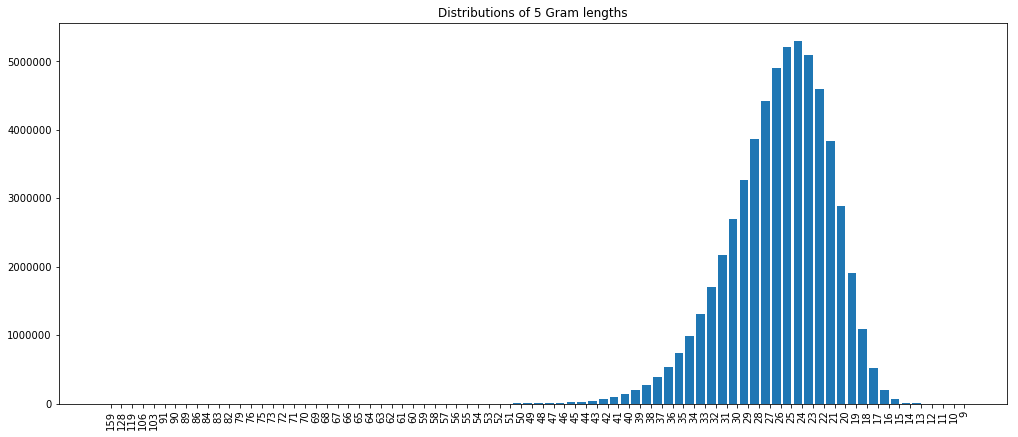

In [53]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("full_distribution.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

## Run times
    Job Name:	streamjob1829799781120004028.jar
    User Name:	nileshbhoyar
    Queue:	berkeley
    State:	SUCCEEDED
    Uberized:	false
    Submitted:	Thu Jun 22 17:40:18 UTC 2017
    Started:	Thu Jun 22 17:40:26 UTC 2017
    Finished:	Thu Jun 22 17:41:55 UTC 2017
    Elapsed:	1mins, 28sec
    Diagnostics:	
    Average Map Time	54sec
    Average Shuffle Time	3sec
    Average Merge Time	0sec
    Average Reduce Time	1sec
    http://rm-ia.s3s.altiscale.com:19888/jobhistory/job/job_1497906899862_2038/mapreduce/job/job_1497906899862_2038

## 3.  HW5.4.2 <a name="5.4.2"></a>OPTIONAL Question: log-log plots (PHASE 2)
[Back to Table of Contents](#TOC)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

## Example MR stats: (report times!)
    took ~11 minutes on 5 m3.xlarge nodes
    Data-local map tasks=188
	Launched map tasks=190
	Launched reduce tasks=15
	Other local map tasks=2

### STOP word removal MR job from output of HW5.4.1 - B.

In [54]:
%%writefile stopremoval.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
 
STOP_WORDS =['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
             'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he',
             'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
             'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
             'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
             'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
             'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
             'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 
             'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
             'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
 
class MRSTOPRemoval(MRJob):
    def mapper(self, _, line):
         fields = line.split("\t")
         word = re.findall("\w+", fields[0])
         if word[0] not in STOP_WORDS:
                yield word[0] ,int(fields[1])
            
    def combiner(self, word, counts):
        yield word, sum(counts)

    def reducer(self, word, counts):
        yield word, sum(counts)
    
    def steps(self):
        return [
            MRStep( 
                    mapper=self.mapper,
                    
                  ),]

if __name__ == '__main__':
    MRSTOPRemoval.run()

Writing stopremoval.py


In [55]:
%time !python stopremoval.py -r local frequentwords.txt_sorted.txt > frequentwords_final.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/stopremoval.nileshbhoyar.20170623.140824.017998
Running step 1 of 1...
Streaming final output from /tmp/stopremoval.nileshbhoyar.20170623.140824.017998/output...
Removing temp directory /tmp/stopremoval.nileshbhoyar.20170623.140824.017998...
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.69 s


In [56]:
!sort  -k2nr -k1 frequentwords_final.txt > frequentwords_final_sorted.txt

In [57]:
!head -10000 frequentwords_final_sorted.txt > vocabulary.txt
!head -10000 frequentwords_final_sorted.txt | tail -1000 > features.txt

In [58]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import csv
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import  combinations
class MRbuildStripes(MRJob):
  
  #START SUDENT CODE531_STRIPES
    SORT_VALUES = True
   
    #def __init__(self, *args, **kwargs):
    #    super(MRjoins, self).__init__(*args, **kwargs)
        
  
    def mapper_init(self):
        self.basis = set()
        self.vocabulary = set()

        with open('features.txt', 'r') as basis_file:
            self.features = set([row[0] for row in csv.reader(basis_file, delimiter = '\t')])

        with open('vocabulary.txt', 'r') as vocabulary_file:
            self.vocabulary = set([row[0] for row in csv.reader(vocabulary_file, delimiter = '\t')])
           
    
        
    def mapper(self, _, recs):
        self.increment_counter('Execution Counts', 'mapper calls', 1)
        fields = recs.split("\t")
        
        products = fields[0].lower().replace('\n','').split()
        for i, term in enumerate(products):
                # Create a new stripe for each term
                stripe = {}
                # check if term is in vocab
                if term not in self.vocabulary:
                        continue
                for j, token in enumerate(products):
                    
                    if i != j:
                        if token not in self.features:
                            continue
                        x = stripe.get(token,None)
                        
                        if x == None:
                            stripe[token] = int( fields[1])
                        else:
                            stripe[token] += int(fields[1])

                # Emit the term and the stripe
                if len(stripe) > 0:
                    yield term, stripe
    
    def combiner(self, word, stripes):
        yield word, self.combine_stripes(stripes)

    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += int(value)
                else:
                    combined_stripe[key] = int(value)

        return combined_stripe
    def reducer(self,key, records):
        yield key, self.combine_stripes(records)
        
    def steps(self):  #pipeline of Map-Reduce jobs
        step = MRStep( 
                    mapper_init=self.mapper_init,
                    mapper=self.mapper,       
                    combiner = self.combiner,
                    reducer=self.reducer,
                    jobconf={
                          'mapreduce.job.reduces': 20,
                           'mapred.map.tasks': 60,
                    }
                    )
        return [step]
            


  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
  MRbuildStripes.run()

Overwriting buildStripes.py


In [59]:
#unit test
!hdfs dfs rm --recursive systems_test_stripes_2
!python buildStripes.py -r hadoop atlas-boon-systems-test.txt --file features.txt --file vocabulary.txt  > systems_test_stripes_2

rm: Unknown command
Did you mean -rm?  This command begins with a dash.
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.nileshbhoyar.20170623.140828.416067
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/buildStripes.nileshbhoyar.20170623.140828.416067/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
 

In [60]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol
class MRinvertedIndex(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    SORT_VALUES = True
#START SUDENT CODE531_INV_INDEX
    def mapper_normalize_transpose(self, word, rate_stripe):



        # Divide each value in the vector by the magnitude to normalize.
        length = len(rate_stripe)
        for key, value in rate_stripe.iteritems():
            #normalized_value = value / magnitude
            yield key, { word: length}
    def combiner_normalize_transpose(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)
    def reducer_normalize_transpose(self, word, transpose_stripes):
        yield word, self.combine_stripes(transpose_stripes)
    def combine_stripes(self, stripes):
        combined_stripe = {}

        for stripe in stripes:
            for key, value in stripe.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

        
    def steps(self):

        transpose_step = MRStep(
            mapper = self.mapper_normalize_transpose,
            combiner = self.combiner_normalize_transpose,
            reducer = self.reducer_normalize_transpose,
            jobconf = {
                    'mapreduce.job.reduces': 10
                })
        return [transpose_step]

#END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Overwriting invertedIndex.py


In [61]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawValueProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class MRsimilarity(MRJob):
    INPUT_PROTOCOL = JSONProtocol
 
    SORT_VALUES = True
    def makeKeyn(self,key, num_reducers):
        byteof = lambda char: int(format(ord(char), 'b'), 2)
        current_hash = 0
        for c in key:
            current_hash = (current_hash * 31 + byteof(c))
        return current_hash % num_reducers
    

#START SUDENT CODE531_SIMILARITY
    def mapper_jaccard(self, word, rate_stripe):
        #get all words and lengths
#We will emit stripes for each word vector here.  These stripes will
#be used in combiner to find the common length i.e. words occuring together
        nonzero_keys = [key for key, value in rate_stripe.iteritems() if value != 0]

       

        sorted_keys = sorted(nonzero_keys)
        mydict = {}
        for key,value in rate_stripe.iteritems():
            mydict[key] = str(value)
        #yield None,mydict
        # N * N  complexity matrix calculation
        #We are going over each record to find out the common occureances
        for i in range(0, len(sorted_keys)):
            
            left_label = sorted_keys[i]

            stripe = {}

            for j in range(i + 1, len(sorted_keys)):
                right_label = sorted_keys[j]
                rkey = right_label+'-'+mydict[right_label]
                stripe[rkey] = 1
            nkey =  left_label+'-'+mydict[left_label]
            if len(stripe) > 0:
                yield self.makeKeyn(left_label,10),(nkey,stripe)

     

        for key in sorted_keys:
            break
            yield '*',{key:1}
            #{u'DocC': 1}
        #yield '*', { key: 1 for key in sorted_keys }
    def combiner_jaccard(self, left_label, partial_stripes):
         #yield left_label,partial_stripes
        for key in partial_stripes:
            #mydict[key] = str(value)
            
           
            yield key[0],[self.combine_stripes(key[1])]
        #yield left_label, self.combine_stripes(partial_stripes)

#find out the jaccard values.
    def reducer_jaccard(self, left_labeltotal, partial_stripes):
        self.increment_counter('reducers_custom', 'counter_name', 1)
    
        
        total_stripe = self.combine_stripess(partial_stripes)
#         yield left_labeltotal , total_stripe
#         return
        #this stores the total length of each word Vector
        if left_labeltotal == '*':
            self.total_counts = total_stripe
            return
        
        for right_label, intersection_size in total_stripe.iteritems():
            left_label,left_total = left_labeltotal.split('-')
            right_label,right_total = right_label.split('-')
            coordinate = (left_label, right_label)
            #union_size = self.total_counts[left_label] + self.total_counts[right_label]

            union_size = float(left_total) + float(right_total)
            jaccard_distance = float(intersection_size)/float(union_size - intersection_size) #jaccard
            dice_coef = (float(intersection_size) * 2 )/float(union_size ) #dice Coefficient
            #final = {}
            #final['jaccard'] = jaccard_distance
            #final['dice'] = dice_coef
            #final['average'] = (float(jaccard_distance) + float(dice_coef)) /2
            #if (final['jaccard'] == final['dice'] ) and final['dice'] == 1:
            #    continue
            #else:
            yield  coordinate, ( jaccard_distance,dice_coef,(float(jaccard_distance) + float(dice_coef)) /2)
           

#in-memory combiner
    def combine_stripes(self, stripes):
        combined_stripe = {}
        
        #for stripe in stripes:
        for key, value in stripes.iteritems():
                if key in combined_stripe:
                    combined_stripe[key] += value
                else:
                    combined_stripe[key] = value

        return combined_stripe

    def combine_stripess(self, stripes_all):
        combined_stripe = {}
        
        for stripe in stripes_all:
            for stripes in stripe:
                for key, value in stripes.iteritems():
                    if key in combined_stripe:
                        combined_stripe[key] += value
                    else:
                        combined_stripe[key] = value

        return combined_stripe
    def steps(self):
        JOBCONF_STEP1 = {
            'stream.num.map.output.key.fields':3,
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            #'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            #'mapreduce.partition.keycomparator.options':'-k3,-3nr',
            'mapred.reduce.tasks': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner',
            'mapreduce.job.maps':20,
        
            }
        distance_step = MRStep(
                mapper = self.mapper_jaccard,
                combiner = self.combiner_jaccard,
                reducer = self.reducer_jaccard,
          
                jobconf= JOBCONF_STEP1
                 )
             
        return [distance_step]
#END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


#### Unit Test 

In [62]:
########################################################################
# Stripes for systems test 3 (given, no need to build stripes)
########################################################################

with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3   

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


In [63]:
!python invertedIndex.py -r local systems_test_stripes_3 > systems_test_index_3

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/invertedIndex.nileshbhoyar.20170623.141044.832312
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.nileshbhoyar.20170623.141044.832312/output...
Removing temp directory /tmp/invertedIndex.nileshbhoyar.20170623.141044.832312...


In [64]:
##########################################################
# Pretty print systems tests for generating Inverted Index
##########################################################

import json

for i in range(3,4):
    print "—"*100
    print "Systems test ",i," - Inverted Index"
    print "—"*100  
    with open("systems_test_index_"+str(i),"r") as f:
        lines = sorted(f.readlines())
        for line in lines:
            line = line.strip()
            word, doc_list = line.split("\t")
            doc_dict = json.loads(doc_list)
            stripe=[]
            for doc in doc_dict:
                stripe.append([doc, doc_dict[doc]])
            stripe=sorted(stripe)
            stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

            print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format(
              (word), stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))

————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  3  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
             "M" |          DocC 4 |                 |                
             "N" |          DocC 4 |                 |                
             "X" |          DocA 3 |          DocB 2 |                
             "Y" |          DocA 3 |          DocB 2 |          DocC 4
             "Z" |          DocA 3 |          DocC 4 |                


In [65]:
!cat systems_test_similarities_3

["DocA", "DocB"]	{"dice": 0.80000000000000004, "jaccard": 0.66666666666666663}
["DocA", "DocC"]	{"dice": 0.5714285714285714, "jaccard": 0.40000000000000002}
["DocB", "DocC"]	{"dice": 0.33333333333333331, "jaccard": 0.20000000000000001}


In [66]:
!python similarity.py -r local systems_test_index_3  > systems_test_similarities_3
!cat systems_test_similarities_3|sort -k3nr

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/similarity.nileshbhoyar.20170623.141046.325690
Running step 1 of 1...
Counters: 1
	reducers_custom
		counter_name=2
Streaming final output from /tmp/similarity.nileshbhoyar.20170623.141046.325690/output...
Removing temp directory /tmp/similarity.nileshbhoyar.20170623.141046.325690...
["DocA","DocB"]	[0.6666666667,0.8,0.7333333333]
["DocA","DocC"]	[0.4,0.5714285714,0.4857142857]
["DocB","DocC"]	[0.2,0.3333333333,0.2666666667]


In [67]:

import json

import random

for i in range(3,2,-1):
  print '—'*110
  print "Systems test ",i," - Similarity measures"
  print '—'*110
  print "{0:>15} |{1:>15}|{2:>15}|{3:>15}".format(
           "pair",  "jaccard","Dice","average")
  print '-'*110

  with open("systems_test_similarities_"+str(i),"r") as f:
      lines = f.readlines()
      for line in lines:
          line = line.strip()
          
          pair,stripe = line.split("\t")
        
            
          result = stripe[1:-1].split(',')
 
          print "{0:>15} |{1:>15f}|{2:>15f}|{3:>15}".format(
              pair,float(result[0]),float(result[1] ),float(result[2]))

 

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  3  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
           pair |        jaccard|           Dice|        average
--------------------------------------------------------------------------------------------------------------
["DocB","DocC"] |       0.200000|       0.333333|   0.2666666667
["DocA","DocC"] |       0.400000|       0.571429|   0.4857142857
["DocA","DocB"] |       0.666667|       0.800000|   0.7333333333


## Run for all Data

In [68]:
# !mkdir /home/nileshbhoyar/output/HW55
# !mkdir /home/nileshbhoyar/output/HW55/stripes
# %time !python buildStripes.py \
#          -r local \
#          --output-dir="/home/nileshbhoyar/output/HW55/stripes"\
#          --no-output \
#          --file features.txt\
#          --file vocabulary.txt\
#         "/home/nileshbhoyar/data/googlebooks-eng-all-5gram-20090715-88-filtered.txt" 
            

In [69]:
!hdfs dfs -mkdir hdfs:///user/nileshbhoyar/output
!hdfs dfs -mkdir hdfs:///user/nileshbhoyar/output/HW55
!hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW55/stripes
%time !python buildStripes.py\
        -r hadoop \
        --output-dir="hdfs:///user/nileshbhoyar/output/HW55/stripes/"\
        --no-output \
        --file features.txt\
        --file vocabulary.txt\
        "hdfs:///user/cendylin/filtered-5Grams/"

mkdir: `hdfs:/user/nileshbhoyar/output': File exists
mkdir: `hdfs:/user/nileshbhoyar/output/HW55': File exists
17/06/23 14:10:54 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/output/HW55/stripes' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/buildStripes.nileshbhoyar.20170623.141055.106020
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/buildStripes.nileshbhoyar.20170623.141055.106020/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop ver

In [70]:
# !mkdir /home/nileshbhoyar/output/HW55/index
# %time !python invertedIndex.py\
#          -r local \
#          --output-dir="/home/nileshbhoyar/output/HW55/index"\
#          --no-output \
#          --file features.txt\
#          --file vocabulary.txt\
#          "/home/nileshbhoyar/output/HW55/stripes"

In [71]:
!hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW55/index

%time !python invertedIndex.py\
        -r hadoop \
        --output-dir="hdfs:///user/nileshbhoyar/output/HW55/index/"\
        --no-output \
        --file features.txt\
        --file vocabulary.txt\
        "hdfs:///user/nileshbhoyar/output/HW55/stripes/"

17/06/23 14:13:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/output/HW55/index' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/invertedIndex.nileshbhoyar.20170623.141337.092588
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/invertedIndex.nileshbhoyar.20170623.141337.092588/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.c

In [ ]:
!hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW55/similarity
%time !python similarity.py\
             -r hadoop \
             --output-dir="hdfs:///user/nileshbhoyar/output/HW55/similarity/"\
             --no-output "hdfs:///user/nileshbhoyar/output/HW55/index"
        
# !hdfs dfs -rm -r hdfs:///user/nileshbhoyar/output/HW55/similarity
# !rm -r /home/nileshbhoyar/output/HW55/similarity/
# %time !python similarity.py\
#          -r local \
#          --output-dir="/home/nileshbhoyar/output/HW55/similarity/"\
#          --no-output \
#          --file features.txt\
#          --file vocabulary.txt\
#          "/home/nileshbhoyar/output/HW55/index/"

17/06/23 14:14:58 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/output/HW55/similarity' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/nileshbhoyar/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/similarity.nileshbhoyar.20170623.141458.960607
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nileshbhoyar/tmp/mrjob/similarity.nileshbhoyar.20170623.141458.960607/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comp

In [ ]:
!rm /home/nileshbhoyar/output/HW55/similarity/part-00000
!hdfs dfs -cat hdfs:///user/nileshbhoyar/output/HW55/similarity/* > /home/nileshbhoyar/output/HW55/similarity/part-00000
!sort -k4nr /home/nileshbhoyar/output/HW55/similarity/part-00000 > final_sorted.txt
!head -1000 final_sorted.txt > result.txt

In [ ]:

import json
from collections import defaultdict

print "{0:>15} |{1:>15}|{2:>15}|{3:>15}".format(
           "pair",  "jaccard","Dice","average")
print '-'*110
ndict = defaultdict(float)
print "{0:>15} |{1:>15}|{2:>15}|{3:>15}".format(
           "pair",  "jaccard","Dice","average")
print '-'*110

with open("result.txt","r") as f:
      lines = f.readlines()
      for line in lines:
          line = line.strip()
          
          pair,stripe = line.split("\t")
        
            
          result = stripe[1:-1].split(',')
 
          print "{0:>15} |{1:>15f}|{2:>15f}|{3:>15}".format(
              pair,float(result[0]),float(result[1] ),float(result[2]))
          

In [ ]:

print "***********************TOP 20 RECORDS****************************"
!head -20 final_sorted.txt
print "\n\n"
print "***********************Bottom 20 Records****************************"
print "\n\n"
!tail -20 final_sorted.txt

## Run time for Stripes Job

    Map 190
    Reducers 20

    Job Name: 	streamjob7789550624839722782.jar
    User Name: 	nileshbhoyar
    Queue: 	berkeley
    State: 	SUCCEEDED
    Uberized: 	false
    Submitted: 	Thu Jun 22 18:17:30 UTC 2017
    Started: 	Thu Jun 22 18:17:39 UTC 2017
    Finished: 	Thu Jun 22 18:19:38 UTC 2017
    Elapsed: 	1mins, 59sec
    Diagnostics: 	
    Average Map Time 	1mins, 17sec
    Average Shuffle Time 	3sec
    Average Merge Time 	0sec
    Average Reduce Time 	2sec 
    
 ## Run time for Inverted index job
 
     NO OF MAPS 20
     NO of REDUCERS 10
     
     Job Name: 	streamjob6234810784634808372.jar
    User Name: 	nileshbhoyar
    Queue: 	berkeley
    State: 	SUCCEEDED
    Uberized: 	false
    Submitted: 	Thu Jun 22 18:20:11 UTC 2017
    Started: 	Thu Jun 22 18:20:19 UTC 2017
    Finished: 	Thu Jun 22 18:23:57 UTC 2017
    Elapsed: 	3mins, 37sec
    Diagnostics: 	
    Average Map Time 	39sec
    Average Shuffle Time 	11sec
    Average Merge Time 	0sec
    Average Reduce Time 	3sec 
    
    
## Run time for similarity jobs
    
    
    Job Name:	streamjob5246956418942942580.jar
    User Name:	nileshbhoyar
    Queue:	berkeley
    State:	SUCCEEDED
    Uberized:	false
    Submitted:	Thu Jun 22 18:24:25 UTC 2017
    Started:	Thu Jun 22 18:25:40 UTC 2017
    Finished:	Thu Jun 22 18:43:19 UTC 2017
    Elapsed:	17mins, 38sec
    Diagnostics:	
    Average Map Time	5mins, 38sec
    Average Shuffle Time	4sec
    Average Merge Time	1sec
    Average Reduce Time	8mins, 13sec

Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

## 3.  HW5.6  <a name="5.6"></a> Evaluation of synonyms that your discovered
[Back to Table of Contents](#TOC)


In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [ ]:
nltk.download('wordnet')

In [ ]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
import re
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
lisst =[]
with open("result.txt","r") as f:
   for line in f.readlines():#

       line = line.strip()
       pair,stripe = line.split("\t")
        
            
       result = stripe[1:-1].split(',')
#        avg,lisst = line.split("\t")
#        lisst = json.loads(lisst)
       lisst.append(result[2])
       top1000sims.append(pair)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    #pair = line[0]
    #words = pair.split(" - ")
    #rec = line[0]
    #print line
    #break
    words = re.findall("\w+", line.lower())
#     print words
#     break
   
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

### Sample output

In [67]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

SyntaxError: invalid syntax (<ipython-input-67-0c3edb848036>, line 1)

## 3.  HW5.7  <a name="5.7"></a> OPTIONAL: using different vocabulary subsets
[Back to Table of Contents](#TOC)


Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

## 3.  HW5.8  <a name="5.8"></a> OPTIONAL: filter stopwords
[Back to Table of Contents](#TOC)

There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



## 3.  HW5.9 <a name="5.9"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## 3.  HW5.10 <a name="5.10"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?